In [1]:
import glob

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.markers import CARETLEFTBASE, CARETRIGHTBASE

all_files = glob.glob("roll_data/*-fouls.csv")

df = pd.concat((pd.read_csv(f, dtype={"stadium_id": "string"}) for f in all_files), ignore_index=True)

# select season (zero indexed)
season = 14
# df = df[df["season"] == season]
print(len(df))
df.groupby("season").size()

126656


season
11    14939
12    18996
13    55903
14    36818
dtype: int64

# Summary

The foul ball formula seems to be something like:
```
foul_threshold = 0.25 + 0.1*fwd - 0.1*obt + (1/30)*( musc + thwack + div)
```
Astrid figured this out last week, but I want to show it in a notebook to make it easier to find.
I have succeeded! It seems that this formula is correct.

## Helper function definitions

In [2]:
def get_pitcher_mul(row):
    pm = str(row["pitcher_mods"])
    ptm = str(row["pitching_team_mods"])
    mul = 1
    if "OVERPERFORMING" in pm:
        mul += 0.2
    if "OVERPERFORMING" in ptm:
        mul += 0.2
    if "UNDERPERFORMING" in pm:
        mul -= 0.2
    if "UNDERPERFORMING" in ptm:
        mul -= 0.2
    if "TRAVELING" in ptm:
        pass  # traveling just doesn't do anything on pitchers?
        # if not row["top_of_inning"]:
        # mul += 0.05
    if "HIGH_PRESSURE" in ptm:
        if row["weather"] == "Weather.FLOODING" and row["baserunner_count"] > 0:
            mul += 0.25
    if "GROWTH" in ptm:
        # mul += min(0.05, 0.05 * (row["day"] / 99))
        pass  # growth doesn't do anything on pitchers either
    if "SINKING_SHIP" in ptm:
        mul += (14 - row["pitching_team_roster_size"]) * 0.01
    if "AFFINITY_FOR_CROWS" in ptm and row["weather"] == "Weather.BIRDS":
        mul += 0.5
    return mul


def get_batter_mul(row):
    bm = str(row["batter_mods"])
    btm = str(row["batting_team_mods"])
    ptm = str(row["pitching_team_mods"])
    mul = 1
    attrs = ""
    if "OVERPERFORMING" in bm:
        mul += 0.2
    if "OVERPERFORMING" in btm:
        mul += 0.2
    if "UNDERPERFORMING" in bm:
        mul -= 0.2
    if "UNDERPERFORMING" in btm:
        mul -= 0.2
    if "TRAVELING" in btm:
        if row["top_of_inning"]:
            # is this actually 0.035 instead of 0.05?
            mul += 0.035
    if "GROWTH" in btm:
        # is this actually 0.035 instead of 0.05?
        mul += min(0.035, 0.035 * (row["day"] / 99))
        pass
    if "HIGH_PRESSURE" in btm:
        if row["weather"] == "Weather.FLOODING" and row["baserunner_count"] > 0:
            mul += 0.25
    if "SINKING_SHIP" in btm:
        mul += (14 - row["batting_team_roster_size"]) * 0.01
    if "AFFINITY_FOR_CROWS" in btm and row["weather"] == "Weather.BIRDS":
        mul += 0.5
    if "CHUNKY" in bm and row["weather"] == "Weather.PEANUTS":
        # todo: make this work if there's also, like, Overperforming active
        # it only should apply to "power" attrs
        mul += 1.0
        attrs = "batter_musclitude, batter_divinity, batter_ground_friction"
    if "SMOOTH" in bm and row["weather"] == "Weather.PEANUTS":
        # todo: make this work if there's also, like, Overperforming active
        # it only should apply to "speed" attrs
        mul += 0.15
        attrs = "batter_musclitude, batter_laserlikeness, batter_ground_friction, batter_continuation"
    if "ON_FIRE" in bm:
        # todo: handle
        # test "+125% multiplier"
        mul += 1.25
        # pass
    # NVGs real??? eclipse weather, special case for Sutton Dreamy
    # surely this will not break from scattering, right? (It totally will)
    if row["batter_name"] == "Sutton Dreamy" and row["weather"] == "Weather.ECLIPSE":
        # NVGs allow the player to play 50% better in a solar eclipse.
        # This might affect fielding and baserunning as well?
        mul += 0.50
    return mul, attrs

## Apply multipliers to data

In [3]:
df[["batter_mul", "batter_mul_attrs"]] = df.apply(get_batter_mul, axis=1, result_type="expand")
df["pitcher_mul"] = df.apply(get_pitcher_mul, axis=1)

for attr in ["batter_musclitude", "batter_thwackability", "batter_divinity"]:
    df[attr+"_scaled"] = df.apply(lambda x: x[attr] * x["batter_mul"]
                                  if (x["batter_mul_attrs"] == "") or (attr in x["batter_mul_attrs"])
                                  else x[attr],
                                  axis=1)



df.loc[df["pitcher_mods"].astype(str).str.contains("SCATTERED"), "pitcher_vibes"] = 0
df.loc[df["batter_mods"].astype(str).str.contains("SCATTERED"), "batter_vibes"] = 0

In [4]:
df = df[(df["batting_team_hype"] == 0) & (df["pitching_team_hype"] == 0)]

df["musc_vibes"] = df["batter_musclitude_scaled"] * (1 + 0.2 * df["batter_vibes"])
df["thwack_vibes"] = df["batter_thwackability_scaled"] * (1 + 0.2 * df["batter_vibes"])
df["div_vibes"] = df["batter_divinity_scaled"] * (1 + 0.2 * df["batter_vibes"])

# put in our "best fit" up here in the original df, just because

df["threshold_best"] = (0.25
                        + 0.10 * df['ballpark_forwardness'] 
                        - 0.10 * df['ballpark_obtuseness'] 
                        + 0.10 * (df["musc_vibes"] + df["thwack_vibes"] + df["div_vibes"]) / 3
                       )

## Exclude data
For instance, can exclude specific mods, or situations with multipliers != 1.0. Here, I'm going to be excluding batters with O No, because that creates tons of foul balls that "shouldn't be" foul balls.

I'm also excluding ON_FIRE (and maybe SPICY) batters because that mod is complicated and I don't want to deal with it right now

In [5]:
dfc = df.copy()

# Sorry, Chorby Short
for exclude_mod in ["O_NO"]:
    # dfc = dfc[~dfc["pitcher_mods"].astype(str).str.contains(exclude_mod)]
    # dfc = dfc[~dfc["pitching_team_mods"].astype(str).str.contains(exclude_mod)]
    dfc = dfc[~dfc["batter_mods"].astype(str).str.contains(exclude_mod)]
    dfc = dfc[~dfc["batting_team_mods"].astype(str).str.contains(exclude_mod)]

# dfc = dfc[(dfc['pitcher_mul'] == 1) & (dfc['batter_mul'] == 1)]



In [6]:
# there are so many columns now, alas
print(list(df.columns))
print(len(df))
print(len(dfc))

['event_type', 'roll', 'passed', 'batter_buoyancy', 'batter_divinity', 'batter_martyrdom', 'batter_moxie', 'batter_musclitude', 'batter_patheticism', 'batter_thwackability', 'batter_tragicness', 'batter_coldness', 'batter_overpowerment', 'batter_ruthlessness', 'batter_shakespearianism', 'batter_suppression', 'batter_unthwackability', 'batter_base_thirst', 'batter_continuation', 'batter_ground_friction', 'batter_indulgence', 'batter_laserlikeness', 'batter_anticapitalism', 'batter_chasiness', 'batter_omniscience', 'batter_tenaciousness', 'batter_watchfulness', 'batter_pressurization', 'batter_cinnamon', 'batter_multiplier', 'runner_on_first_buoyancy', 'runner_on_first_divinity', 'runner_on_first_martyrdom', 'runner_on_first_moxie', 'runner_on_first_musclitude', 'runner_on_first_patheticism', 'runner_on_first_thwackability', 'runner_on_first_tragicness', 'runner_on_first_coldness', 'runner_on_first_overpowerment', 'runner_on_first_ruthlessness', 'runner_on_first_shakespearianism', 'runne

In [20]:
# preparing a useful digest list of columns for later
digest_list = [
    "event_type",
    "passed",
    "roll",
    "threshold",
    "offset",
    "threshold_best",
    "batter_name",
    # "pitcher_name",
    "div_vibes",
    "musc_vibes",
    "thwack_vibes",
    "ballpark_forwardness",
    "ballpark_obtuseness",
    "game_id",
    "play_count",
    "batter_mul",
    # "pitcher_mul",
    "batter_mods",
    "batting_team_mods",
    # "pitcher_mods",
    # "pitching_team_mods",
    "weather",
    "batter_consecutive_hits",
]

### Preliminary plot

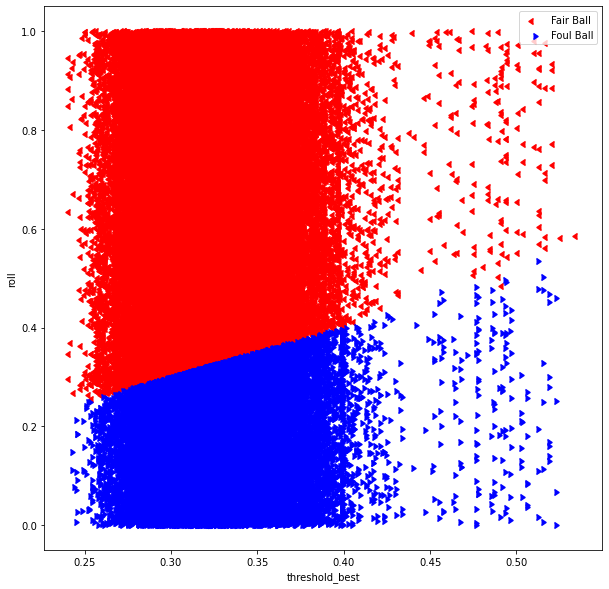

In [8]:
# x_val = "ruth_scaled"
x_val = "threshold_best"
fig, ax = plt.subplots(1, figsize=(10, 10))
ax.scatter(
    dfc[~dfc["passed"]][x_val],
    dfc[~dfc["passed"]]["roll"],
    color="red",
    label="Fair Ball",
    marker=CARETLEFTBASE,
)
ax.scatter(
    dfc[dfc["passed"]][x_val],
    dfc[dfc["passed"]]["roll"],
    color="blue",
    label="Foul Ball",
    marker=CARETRIGHTBASE,
)
ax.set_xlabel(x_val)
ax.set_ylabel("roll")
# ax.set_xlim(0.484, 0.499)

ax.legend()

# fig.savefig(x_val + ".png", facecolor="white")

## SVC fit

In [9]:
# The "include "passed" in X and then drop it" stuff is useful if you need to exclude a range of rolls,
# say because there's a max value for the threshold (like in the strike zone formula).
X = dfc[["passed",
         "roll",
         "div_vibes",
         "musc_vibes",
         "thwack_vibes",
         "ballpark_forwardness",
         "ballpark_obtuseness"]].copy()

# X = X[X["roll"] < 0.85]
y = X["passed"]
X = X.drop(["passed"], axis=1)
len(X)

118872

In [10]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import svm


sc = StandardScaler()
X2 = sc.fit_transform(X)

trainedsvm = svm.LinearSVC(dual=False, max_iter=100000, C=1000000, tol=1e-10).fit(X2, y)
predictionsvm = trainedsvm.predict(X2)
print(confusion_matrix(y, predictionsvm))
print(classification_report(y, predictionsvm))
print(trainedsvm.score(X2, y))

[[80450    26]
 [   22 38374]]
              precision    recall  f1-score   support

       False       1.00      1.00      1.00     80476
        True       1.00      1.00      1.00     38396

    accuracy                           1.00    118872
   macro avg       1.00      1.00      1.00    118872
weighted avg       1.00      1.00      1.00    118872

0.9995962043206138


In [11]:
coef = np.true_divide(trainedsvm.coef_, sc.scale_)
coef_scaled = coef / coef[0, 0]
coef_list = coef_scaled.tolist()[0]
intercept = trainedsvm.intercept_ - np.dot(coef, sc.mean_)
intercept_scaled = intercept / coef[0, 0]

print(intercept_scaled)
sorted(zip(coef_list, X.columns), key=lambda x: abs(x[0]), reverse=True)

[-0.24886608]


[(1.0, 'roll'),
 (-0.10176721045639438, 'ballpark_forwardness'),
 (0.10144469472702726, 'ballpark_obtuseness'),
 (-0.03475841368916227, 'thwack_vibes'),
 (-0.03366719327867867, 'div_vibes'),
 (-0.03296118272152225, 'musc_vibes')]

## Calculate threshold from fit

In [12]:
dfc['threshold'] = -intercept_scaled[0]
print(-intercept_scaled)
for pair in zip(-np.array(coef_list), X.columns):
    if pair[1] != "roll":
        print(pair)
        dfc['threshold'] += pair[0] * dfc[pair[1]]

# if you want to do a manual version instead, put it here

dfc["threshold"] = (0.25
                    + 0.10 * df['ballpark_forwardness']
                    - 0.10 * df['ballpark_obtuseness']
                    + 0.10 * (df["musc_vibes"] + df["thwack_vibes"] + df["div_vibes"]) / 3
                    )

[0.24886608]
(0.03366719327867867, 'div_vibes')
(0.03296118272152225, 'musc_vibes')
(0.03475841368916227, 'thwack_vibes')
(0.10176721045639438, 'ballpark_forwardness')
(-0.10144469472702726, 'ballpark_obtuseness')


## Find Outliers

7


,event_type,passed,roll,threshold,offset,threshold_best,batter_name,div_vibes,musc_vibes,thwack_vibes,ballpark_forwardness,ballpark_obtuseness,game_id,play_count,batter_mul,batter_mods,batting_team_mods,weather,batter_consecutive_hits,season
11592,uhhhhh,True,0.533847,0.511412,0.022435,0.511412,Sandie Turner,2.325407,2.307703,2.937322,0.563717,0.473072,0fa130a4-05b4-4428-974a-23cc56a18174,253,2.25,SPICY;PERK;ON_FIRE,BIRD_SEED,Weather.REVERB,24,14
7083,uhhhhh,True,0.471291,0.455081,0.016210,0.455081,Conner Haley,2.550626,1.419489,2.339794,0.574211,0.626709,144f1822-c451-415f-a4a2-7d469fd4aab6,284,2.25,SPICY;ON_FIRE,NaN,Weather.COFFEE_3S,2,14
16931,uhhhhh,True,0.482707,0.475188,0.007518,0.475188,Conner Haley,2.550626,1.419489,2.339794,0.566199,0.417617,c9c59adb-4f45-4c89-9d75-f19d95701e7e,236,2.25,SPICY;ON_FIRE,NaN,Weather.FLOODING,0,14
92572,uhhhhh,True,0.496834,0.492430,0.004404,0.492430,Sandie Turner,2.387644,2.369467,3.015936,0.596960,0.763673,d4d7fc48-3b4c-47c5-b1a0-2a6c2948b407,259,2.25,SPICY;PERK;ON_FIRE,BIRD_SEED,Weather.FEEDBACK,1,13
75433,uhhhhh,True,0.424903,0.423788,0.001115,0.423788,Theodore Duende,2.421136,0.759174,1.761388,0.563717,0.473072,27100629-f8ad-4b81-8a5f-54a596486860,109,2.25,SPICY;ON_FIRE,NaN,Weather.FLOODING,3,13
26357,uhhhhh,True,0.492880,0.492874,0.000006,0.492874,Conner Haley,2.765100,1.538849,2.536541,0.566199,0.417617,67fb8a85-7bd9-42b0-9470-5553b5633728,156,2.25,SPICY;ON_FIRE,NaN,Weather.ECLIPSE,4,13
31376,uhhhhh,False,0.484395,0.491975,-0.007580,0.491975,Beans McBlase,2.725026,3.655222,1.276391,0.536745,0.669207,3758cccc-ef21-48c1-88ae-4cd36e7cb16f,280,2.25,SIPHON;SPICY;PERK;ON_FIRE,HIGH_PRESSURE,Weather.BIRDS,3,13


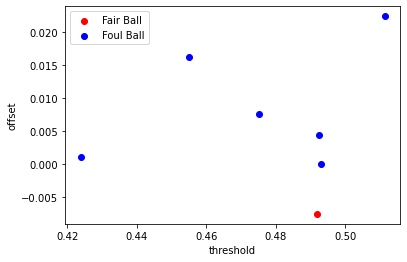

In [21]:
dfc["offset"] = dfc["roll"] - dfc["threshold"]
outliers = dfc[(dfc["passed"] & (dfc["offset"] >= 0)) | (~dfc["passed"] & (dfc["offset"] <= 0))]

fig, ax = plt.subplots(1)
x_val = "threshold"
ax.scatter(
    outliers[~outliers["passed"]][x_val],
    outliers[~outliers["passed"]]["offset"],
    color="red",
    label="Fair Ball",
)
ax.scatter(
    outliers[outliers["passed"]][x_val],
    outliers[outliers["passed"]]["offset"],
    color="blue",
    label="Foul Ball",
)
ax.set_xlabel(x_val)
ax.set_ylabel("offset")
ax.legend()

table = outliers
print(len(outliers))
table[[*digest_list, "season"]].sort_values("offset", ascending=False)

In [30]:
testgame = 'c9c59adb-4f45-4c89-9d75-f19d95701e7e'
# testdf = dfc[(dfc['game_id'] == testgame) & (dfc['batter_name'] == "Conner Haley")]
testdf = dfc[(dfc['batter_name'] == "Sandie Turner")]

In [34]:
testdf.loc[:, digest_list].sort_values("batter_consecutive_hits", ascending=False)[0:20]

,event_type,passed,roll,threshold,offset,threshold_best,batter_name,div_vibes,musc_vibes,thwack_vibes,ballpark_forwardness,ballpark_obtuseness,game_id,play_count,batter_mul,batter_mods,batting_team_mods,weather,batter_consecutive_hits
14113,uhhhhh,False,0.387561,0.329771,0.057790,0.329771,Sandie Turner,0.888725,0.881959,1.122587,0.596960,0.763673,ba93cba2-2e6a-4934-a55d-f82b4a28063c,213,1.00,SPICY;PERK,BIRD_SEED,Weather.FLOODING,35
13941,uhhhhh,False,0.852387,0.329771,0.522616,0.329771,Sandie Turner,0.888725,0.881959,1.122587,0.596960,0.763673,ba93cba2-2e6a-4934-a55d-f82b4a28063c,150,1.00,SPICY;PERK,BIRD_SEED,Weather.FLOODING,35
13937,uhhhhh,True,0.266093,0.329771,-0.063678,0.329771,Sandie Turner,0.888725,0.881959,1.122587,0.596960,0.763673,ba93cba2-2e6a-4934-a55d-f82b4a28063c,149,1.00,SPICY;PERK,BIRD_SEED,Weather.FLOODING,35
13821,uhhhhh,False,0.695215,0.329771,0.365444,0.329771,Sandie Turner,0.888725,0.881959,1.122587,0.596960,0.763673,ba93cba2-2e6a-4934-a55d-f82b4a28063c,104,1.00,SPICY;PERK,BIRD_SEED,Weather.FLOODING,35
13615,uhhhhh,False,0.979116,0.450324,0.528792,0.450324,Sandie Turner,1.999632,1.984408,2.525821,0.596960,0.763673,ba93cba2-2e6a-4934-a55d-f82b4a28063c,30,2.25,SPICY;PERK;ON_FIRE,BIRD_SEED,Weather.FLOODING,35
13307,uhhhhh,True,0.278209,0.488834,-0.210625,0.488834,Sandie Turner,2.117351,2.101232,2.674518,0.563717,0.473072,2eca579c-24df-4741-98b5-352f02e8eb43,224,2.25,SPICY;PERK;ON_FIRE,BIRD_SEED,Weather.BIRDS,33
13302,uhhhhh,True,0.182694,0.488834,-0.306141,0.488834,Sandie Turner,2.117351,2.101232,2.674518,0.563717,0.473072,2eca579c-24df-4741-98b5-352f02e8eb43,223,2.25,SPICY;PERK;ON_FIRE,BIRD_SEED,Weather.BIRDS,33
13140,uhhhhh,False,0.905159,0.488834,0.416325,0.488834,Sandie Turner,2.117351,2.101232,2.674518,0.563717,0.473072,2eca579c-24df-4741-98b5-352f02e8eb43,167,2.25,SPICY;PERK;ON_FIRE,BIRD_SEED,Weather.BIRDS,33
12655,uhhhhh,False,0.889750,0.488834,0.400915,0.488834,Sandie Turner,2.117351,2.101232,2.674518,0.563717,0.473072,2eca579c-24df-4741-98b5-352f02e8eb43,9,2.25,SPICY;PERK;ON_FIRE,BIRD_SEED,Weather.BIRDS,33
12275,uhhhhh,False,0.654578,0.501174,0.153404,0.501174,Sandie Turner,2.231062,2.214077,2.818151,0.563717,0.473072,34b1bc68-541f-4a74-baa8-85e180239675,179,2.25,SPICY;PERK;ON_FIRE,BIRD_SEED,Weather.SALMON,28


In [16]:
print(coef_scaled[0, :], intercept_scaled)

[ 1.         -0.03366719 -0.03296118 -0.03475841 -0.10176721  0.10144469] [-0.24886608]


## Visualize Threshold

Text(0.5, 0.98, 'Season 15')

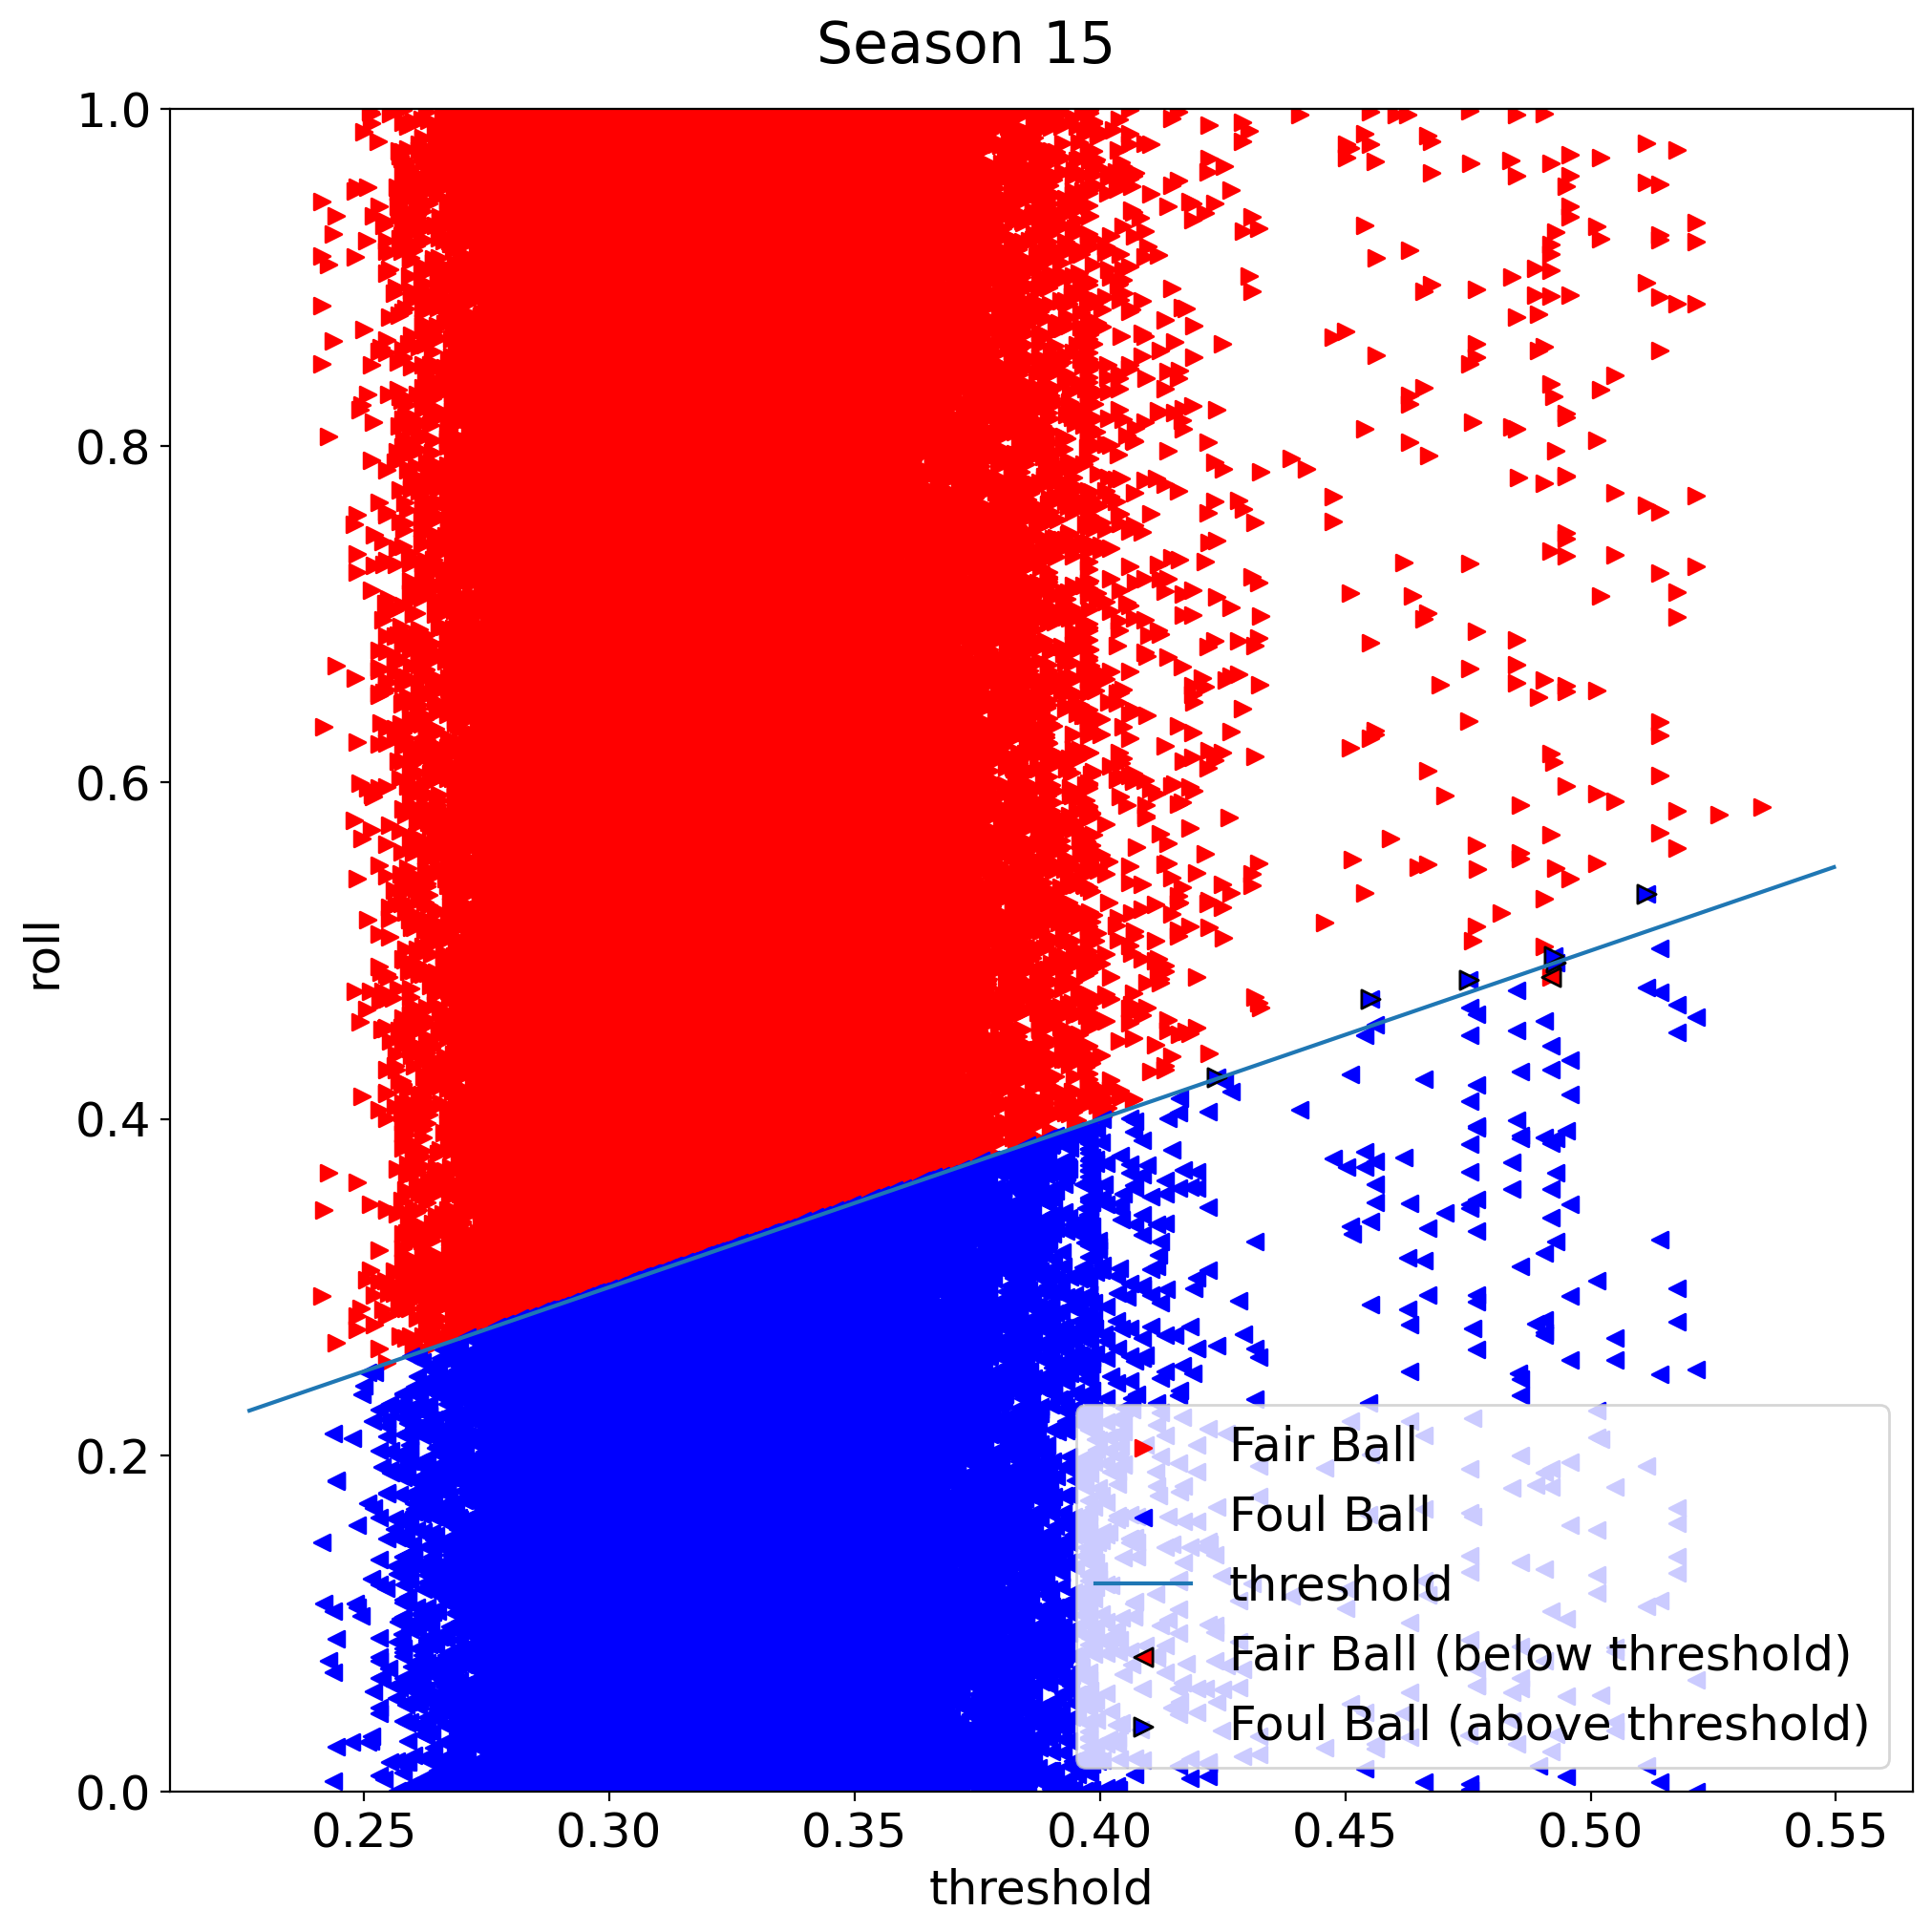

In [17]:
# x_val = "pitcher_ruthlessness"

plt.rcParams["font.size"] = 18
x_val = "threshold"
fig, ax = plt.subplots(1, figsize=(10, 10), dpi=200, layout="constrained")

ax.set_ylim(0, 1)
ax.scatter(
    dfc[~dfc["passed"]][x_val],
    dfc[~dfc["passed"]]["roll"],
    color="red",
    label="Fair Ball",
    marker=">",
)
ax.scatter(
    dfc[dfc["passed"]][x_val],
    dfc[dfc["passed"]]["roll"],
    color="blue",
    label="Foul Ball",
    marker="<",
)
xline = ax.get_xlim()
yline = xline
ax.plot(xline, yline, label="threshold")
if len(outliers) > 0:
    ax.scatter(outliers[~outliers['passed']][x_val], outliers[~outliers['passed']]["roll"],
               s=48, edgecolor='black', color="red", label="Fair Ball (below threshold)", marker='<')
    ax.scatter(outliers[outliers['passed']][x_val], outliers[outliers['passed']]["roll"],
               s=48, edgecolor='black', color="blue", label="Foul Ball (above threshold)", marker='>')
ax.set_xlabel(x_val)
ax.set_ylabel("roll")
# ax.set_ylim(0.85, 0.86)

ax.legend(loc="lower right")
fig.suptitle(f"Season {season+1}")
# fig.savefig("strikes_s14_flinch.png", facecolor='white', dpi=200)
# endpoints = np.array(ax.get_xlim())
# ax.plot(endpoints, 0.35 + 0.35 * endpoints)

In [18]:
outliers.groupby("season").size()

season
13    4
14    3
dtype: int64

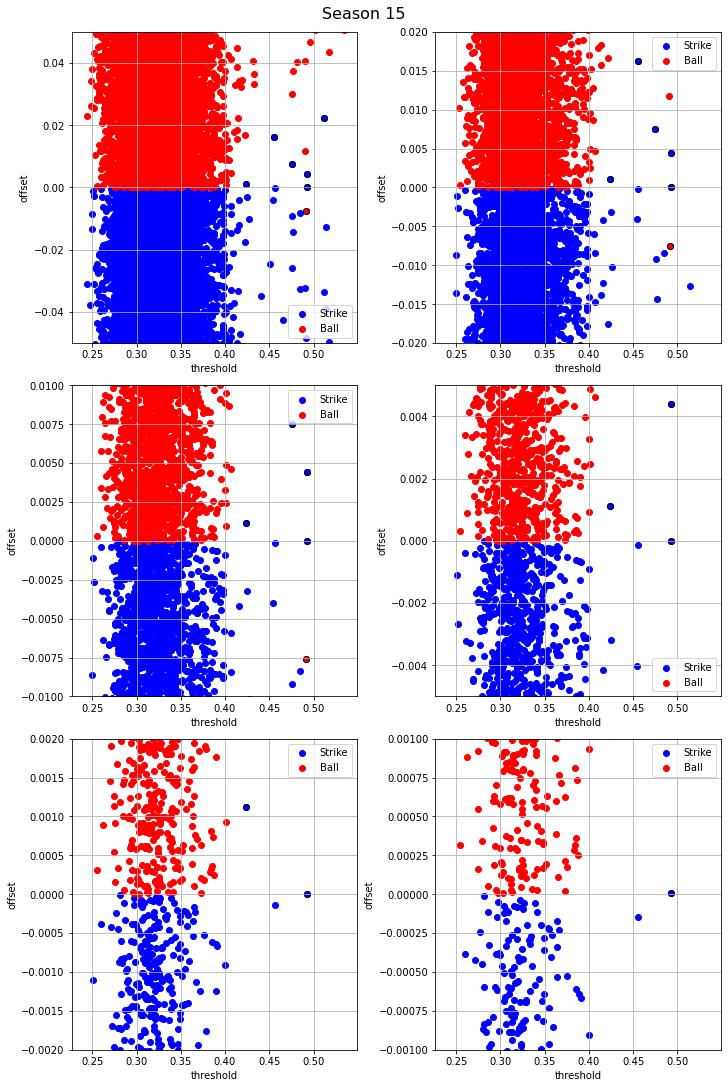

In [19]:
plt.rcParams["font.size"] = 10
x_val = "threshold"
fig, axes = plt.subplots(3, 2, figsize=(10, 15), constrained_layout=True)
fig.suptitle(f"Season {season+1}", fontsize=16)
dimlist = [5e-2, 2e-2, 1e-2, 0.5e-2, 0.2e-2, 0.1e-2]
for i, ax in enumerate(np.ravel(axes)):
    ax.scatter(
        dfc[dfc["passed"]][x_val],
        dfc[dfc["passed"]]["offset"],
        color="blue",
        label="Strike",
    )
    ax.scatter(
        dfc[~dfc["passed"]][x_val],
        dfc[~dfc["passed"]]["offset"],
        color="red",
        label="Ball",
    )
    ax.scatter(
        outliers[~outliers["passed"]][x_val],
        outliers[~outliers["passed"]]["offset"],
        color="red",
        edgecolor="black",
    )
    ax.scatter(
        outliers[outliers["passed"]][x_val],
        outliers[outliers["passed"]]["offset"],
        color="blue",
        edgecolor="black",
    )
    ax.set_xlabel(x_val)
    ax.set_ylabel("offset")
    ax.legend()
    ax.grid()
    ax.set_ylim(-dimlist[i], dimlist[i])
# fig.savefig("ball_strike_fit_offsets.png", facecolor='white')